# Women ecommerce review analysis
## Prepare environment

In [3]:
# Install libraries

! {sys.executable} -m pip install -U pandas-profiling[notebook]
! jupyter nbextension enable --py widgetsnbextension
! pip install opendatasets
! pip install spacy
! pip install spacytextblob
! python -m textblob.download_corpora
! python -m spacy download en_core_web_sm
! pip install openai

/bin/bash: line 1: {sys.executable}: command not found
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-dat

In [38]:
# Import libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
import opendatasets as od
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import re
import openai
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data preprocessing

In [ ]:
# Load dataset

od.download("https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews")
df = pd.read_csv("womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")
df.sample(5)

In [7]:
# Perform data cleansing

df[["Clothing ID","Recommended IND"]] = df[["Clothing ID","Recommended IND"]].astype(str)
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna(subset=['Division Name', 'Department Name', 'Class Name','Review Text'])
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Clothing ID,22628,1172,1078,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,22628.0,NaN,NaN,NaN,43.28288,12.328176,18.0,34.0,41.0,52.0,99.0
Title,19662,13983,Love it!,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,22628,22621,Perfect fit and i've gotten so many compliment...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,22628.0,NaN,NaN,NaN,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,22628,2,1,18527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Positive Feedback Count,22628.0,NaN,NaN,NaN,2.631784,5.78752,0.0,0.0,1.0,3.0,122.0
Division Name,22628,3,General,13365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,22628,6,Tops,10048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class Name,22628,20,Dresses,6145,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Filter data

condition1 = df['Review Text'].map(df["Review Text"].value_counts()>1) # Remove duplicate reviews
condition2 = df["Positive Feedback Count"]==0 # Only keep reviews with at least 1 positive feedback
df = df[~(condition1|condition2)]

id_counts = df["Clothing ID"].value_counts() # Get Clothing ID with more than 100 reviews
high_reviews_id = id_counts[id_counts > 100].index.tolist()
filtered_df = df[df['Clothing ID'].isin(high_reviews_id)] # Filter data frame to only include the top reviews Clothing ID

# Identify total rows of high reviewed Clothing ID
print(filtered_df.shape)
print(len(set(filtered_df["Clothing ID"]))) # Sanity check if the filter is correct

(5816, 10)
31


In [10]:
# Check data out

filtered_df = filtered_df.groupby(['Division Name','Department Name', 'Class Name','Age','Clothing ID','Review Text'], dropna=False).agg(
    {"Positive Feedback Count":np.sum
     , "Rating" : np.average}).reset_index()
display(filtered_df.head())
display(filtered_df.describe(include="all").T)

,Division Name,Department Name,Class Name,Age,Clothing ID,Review Text,Positive Feedback Count,Rating
0,General,Bottoms,Jeans,21,1022,These jeans are awesome! i usually wear a 26 i...,6,4.0
1,General,Bottoms,Jeans,21,1033,Loved these when i tried them on they fit well...,3,2.0
2,General,Bottoms,Jeans,23,1022,"The wash is just as pictured, and the fit is g...",2,5.0
3,General,Bottoms,Jeans,25,1022,I absolutely love ag stevie ankle jeans and ow...,1,5.0
4,General,Bottoms,Jeans,25,1022,"These jeans are so great, i'm thinking of gett...",8,5.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Division Name,5816,2,General,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,5816,3,Tops,2788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class Name,5816,7,Dresses,2658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,5816.0,NaN,NaN,NaN,43.931396,12.367847,19.0,35.0,42.0,53.0,99.0
Clothing ID,5816,31,1078,517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,5816,5816,These jeans are awesome! i usually wear a 26 i...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Positive Feedback Count,5816.0,NaN,NaN,NaN,5.264099,7.903702,1.0,1.0,3.0,6.0,122.0
Rating,5816.0,NaN,NaN,NaN,4.155433,1.13942,1.0,4.0,5.0,5.0,5.0


In [11]:
agg_filtered_df = filtered_df.groupby(['Division Name','Department Name', 'Class Name']).agg({
    'Review Text' : 'count'
    , 'Clothing ID' : pd.Series.nunique
    , 'Age':np.average
    , 'Positive Feedback Count' : np.sum
    , 'Rating' : np.average
}).reset_index()
agg_filtered_df['Average Review per CID'] = agg_filtered_df['Review Text']/agg_filtered_df['Clothing ID']
agg_filtered_df

,Division Name,Department Name,Class Name,Review Text,Clothing ID,Age,Positive Feedback Count,Rating,Average Review per CID
0,General,Bottoms,Jeans,150,2,42.766667,511,4.340000,75.000
1,General,Bottoms,Pants,121,1,46.223140,618,4.223140,121.000
2,General,Dresses,Dresses,1614,12,42.334572,9043,4.171623,134.500
3,General,Tops,Blouses,477,5,45.406709,2511,4.243187,95.400
4,General,Tops,Fine gauge,103,1,45.699029,446,4.174757,103.000
5,General,Tops,Knits,1027,8,45.207400,5140,4.060370,128.375
6,General,Tops,Sweaters,149,2,46.899329,694,4.187919,74.500
7,General Petite,Bottoms,Jeans,66,2,43.575758,245,4.590909,33.000
8,General Petite,Bottoms,Pants,33,1,47.727273,138,4.515152,33.000
9,General Petite,Dresses,Dresses,1044,12,42.793103,6199,4.094828,87.000


In [13]:
# Sanity check Clothing ID

filtered_df.groupby(['Clothing ID']).agg({
    'Division Name':pd.Series.nunique
    ,'Department Name': pd.Series.nunique
    ,'Class Name':pd.Series.nunique

}).head(5)

,Division Name,Department Name,Class Name
Clothing ID,,,
1022,2,1,1
1033,2,1,1
1059,2,1,1
1072,2,1,1
1077,2,1,1


In [15]:
# Filter data for dress in general division only

df_text = filtered_df.query('`Division Name`=="General" & `Department Name`=="Dresses" & `Class Name` == "Dresses"' )
df_text.sample(5)

,Division Name,Department Name,Class Name,Age,Clothing ID,Review Text,Positive Feedback Count,Rating
529,General,Dresses,Dresses,31,1072,"What a dress! the print, the feel of the fabri...",4,5.0
443,General,Dresses,Dresses,28,1094,"I ordered the black and white version online, ...",5,5.0
493,General,Dresses,Dresses,30,1077,Comfortable fabric and beautiful print! light ...,1,4.0
565,General,Dresses,Dresses,31,1110,"Perfect summer dress: feminine, cool, with jus...",2,5.0
683,General,Dresses,Dresses,34,1083,I would not have spent this much on a dress wi...,2,5.0


## Text Analysis


In [16]:
# SpaCy sentiments function

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

def get_sentiments(text_review):
  doc = nlp(text_review)
  sentiment = doc._.blob.polarity
  sentiment = round(sentiment,2)
  label = "NEGATIVE"
  label = "POSITIVE" if (sentiment > 0) else "NEGATIVE"

  positive_words = []
  negative_words = []
  adjective_words = []

  for word in doc._.blob.sentiment_assessments.assessments:
    if word[1] > 0:
      positive_words.append(word[0][0])
    elif word[1] < 0:
      negative_words.append(word[0][0])
    else:
      pass

  for token in doc:
    if token.pos_ == ("ADJ"):
      adjective_words.append(token)

  return label, sentiment, positive_words, negative_words, adjective_words

In [32]:
# Word cloud generator function

def create_wordclouds(text, title):
  stop_words = list(STOPWORDS)
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(text))
  plt.figure()
  plt.title(title)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

In [21]:
# Fetching sentiment analysis into our dataframe

df_spacy = df_text.copy()
df_spacy["spacy_analysis"] = [get_sentiments(rev) for rev in df_spacy["Review Text"]]
df_spacy["spacy_sentiment"] = [i[0] for i in df_spacy["spacy_analysis"]]
df_spacy["spacy_score"] = [i[1] for i in df_spacy["spacy_analysis"]]
df_spacy["spacy_pos"] = [i[2] for i in df_spacy["spacy_analysis"]]
df_spacy["spacy_neg"] = [i[3] for i in df_spacy["spacy_analysis"]]
df_spacy["spacy_adjective"] = [i[4] for i in df_spacy["spacy_analysis"]]
df_spacy.sample(5)

,Division Name,Department Name,Class Name,Age,Clothing ID,Review Text,Positive Feedback Count,Rating,spacy_analysis,spacy_sentiment,spacy_score,spacy_pos,spacy_neg,spacy_adjective
1190,General,Dresses,Dresses,43,1078,I loved this dress as soon as i saw it online....,1,5.0,"(POSITIVE, 0.43, [loved, high, perfect, super,...",POSITIVE,0.43,"[loved, high, perfect, super, comfortable, ver...",[other],"[high, nervous, knit, clingy, stretchy, scratc..."
836,General,Dresses,Dresses,36,1110,"I recently purchased this dress in the yellow,...",23,5.0,"(POSITIVE, 0.22, [glad, vibrant, loud, really,...",POSITIVE,0.22,"[glad, vibrant, loud, really, more, perfect, a...","[little, down]","[glad, vibrant, loud, little, larger, more, pe..."
659,General,Dresses,Dresses,33,1095,I was so pumped to see a slightly different ve...,9,4.0,"(POSITIVE, 0.09, [loved, right, right, much, c...",POSITIVE,0.09,"[loved, right, right, much, comfortable]","[military, less, much, dramatic]","[different, last, military, voluminous, short,..."
282,General,Dresses,Dresses,21,1086,This dress is beautiful. i cannot begin to exp...,2,5.0,"(POSITIVE, 0.31, [beautiful, pleased, more, ea...",POSITIVE,0.31,"[beautiful, pleased, more, early, light, incre...",[],"[beautiful, pleased, early, 20th, light, comfo..."
451,General,Dresses,Dresses,28,1110,This dress is absolutely gorgeous. the fabric ...,1,5.0,"(POSITIVE, 0.3, [absolutely, light, comfortabl...",POSITIVE,0.30,"[absolutely, light, comfortable, more, vibrant...","[long, mean]","[gorgeous, light, comfortable, vibrant, only, ..."


In [22]:
# Identifiying highest reviewed Clothing ID for next analysis

df_spacy["Clothing ID"].value_counts()

1078    330
1094    236
1110    205
1086    124
1080    118
1081    105
1095    102
1077    100
1083     97
1092     74
1072     68
1104     55
Name: Clothing ID, dtype: int64

In [23]:
cid_1078 = df_spacy.query("`Clothing ID`=='1078'")
cid_1078.spacy_sentiment.value_counts()

POSITIVE    310
NEGATIVE     20
Name: spacy_sentiment, dtype: int64

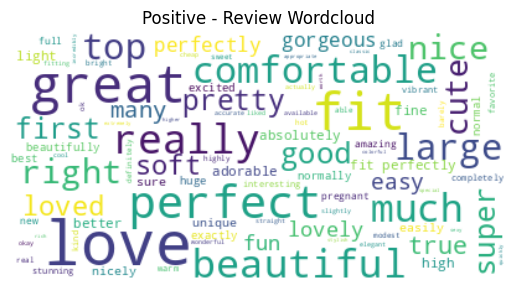

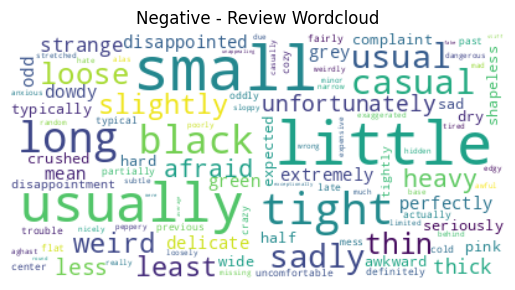

In [33]:
# Generate Word Cloud - Words

positive_rev = re.sub(r"[^ a-zA-Z0-9]+",'',' '.join(cid_1078["spacy_pos"].astype(str))) # Melt all the text together and strip special characters for postive words
negative_rev = re.sub(r"[^ a-zA-Z0-9]+",'',' '.join(cid_1078["spacy_neg"].astype(str))) # Melt all the text together and strip special characters for negative words

create_wordclouds(positive_rev, "Positive - Review Wordcloud")
create_wordclouds(negative_rev, "Negative - Review Wordcloud")

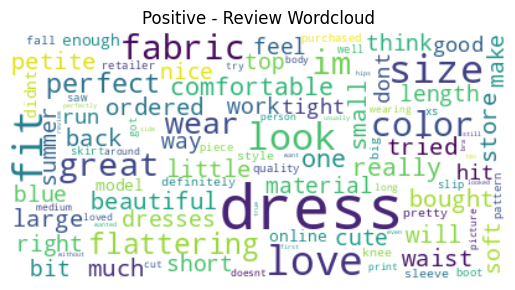

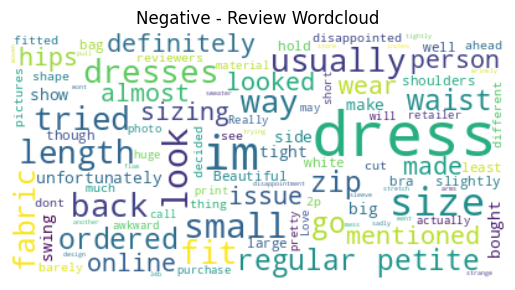

In [35]:
# Generate Word Cloud - Review Text

positive_rev = re.sub(r"[^ a-zA-Z0-9]+",'',' '.join(cid_1078.query("spacy_sentiment == 'POSITIVE'")["Review Text"].astype(str)))
negative_rev = re.sub(r"[^ a-zA-Z0-9]+",'',' '.join(cid_1078.query("spacy_sentiment == 'NEGATIVE'")["Review Text"].astype(str)))

create_wordclouds(positive_rev, "Positive - Review Wordcloud")
create_wordclouds(negative_rev, "Negative - Review Wordcloud")

In [41]:
# Concatenate all negatively identified sentiment
positive_reviews = cid_1078.query("spacy_sentiment == 'NEGATIVE'")
out = ' '.join(positive_reviews["Review Text"])

In [39]:
# Set your OpenAI API key
api_key = ''
openai.api_key = api_key

# Define the product review text
product_review = out # update this

# Preprocess the text - remove special characters, numbers, and stopwords
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

# Tokenize the text into sentences
sentences = sent_tokenize(product_review)

# Initialize a list to store cleaned sentences
cleaned_sentences = []

# Preprocess and filter out stopwords
stop_words = set(stopwords.words('english'))
for sentence in sentences:
    cleaned_sentence = preprocess_text(sentence)
    if cleaned_sentence and cleaned_sentence not in stop_words:
        cleaned_sentences.append(cleaned_sentence)

# Join the cleaned sentences back into a single string
cleaned_review = ' '.join(cleaned_sentences)

# Define a function to generate a summary using GPT-3
def generate_summary(text):
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"Summarize the following text: {text}",
        max_tokens=50,  # Adjust the number of tokens for desired summary length
        temperature=0.7,  # Adjust the temperature for creativity vs. focus
    )
    return response.choices[0].text.strip()


In [40]:
# Generate a summary of the product review
summary = generate_summary(cleaned_review)

# Print the summary
print("Original Review:\n", product_review)
print("\nGenerated Summary:\n", summary)

Original Review:
 Beautiful, washes well in a garment bag on delicate. has little clips in the shoulders to hold bra straps which is crucial with the scoop back if you have sloped shoulders like mine. i normally go for a large, but was definitely a medium in this dress. 32" waist, 32f bra, 
only minor complaint is that the pattern (at least on the red, though probably also on the others) is just printed on the outside and the inside is faded almost white, so since the sides of the dress are slightly longer than I ordered this dress online in order to get a petite size and am very disappointed. as other reviewers have mentioned, the fabric overlay is very different in person than it appears in the online pictures. the dress is much more casual and looks cheaply made in person. 
as for sizing, i ordered the 2p based on other reviewers' comments about it running small. the 2p fit me fine, although it was very fitted in the chest and i am very small chested #32b#. i can definitely see that